#Import the input image
A standard color image (Lena) is loaded into Python.

#Convert the image to grayscale
The color image is converted into a grayscale image to simplify processing.

#Add noise to the image

Gaussian noise is added to simulate sensor noise.

Salt and pepper noise is added to simulate impulse noise.

Motion blur is added using a motion blur kernel.

# Apply restoration filters

Median filter is applied to remove salt and pepper noise.

Wiener filter is applied to remove Gaussian noise.

Inverse filter is applied to restore motion blurred image.

# Restore motion blurred image
Motion blur is restored using both inverse filtering and Wiener filtering.

# Evaluate restoration quality
PSNR is calculated between the original image and restored images.

# Compare results
The restoration method giving the highest PSNR is considered the best.

# Draw conclusion

Wiener filter works best for Gaussian noise and motion blur.

Median filter works best for salt and pepper noise.

In [1]:
# 1. Import Required Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.signal import convolve2d
from scipy.fftpack import fft2, ifft2, fftshift

(np.float64(-0.5), np.float64(335.5), np.float64(336.5), np.float64(-0.5))

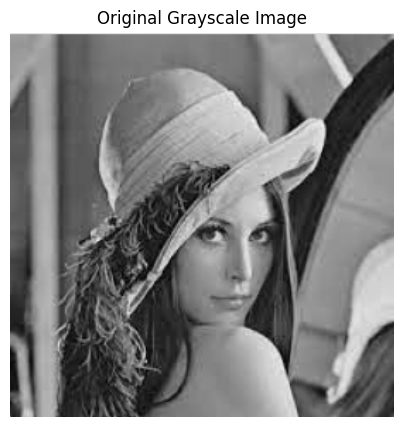

In [2]:
# 2. Load Color Image & Convert to Grayscale

# Load image (make sure lena.jpg/png is uploaded in Colab)
img_color = cv2.imread('lena.png')   # change extension if needed
img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

# Convert to grayscale
img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(5,5))
plt.imshow(img_gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

(np.float64(-0.5), np.float64(335.5), np.float64(336.5), np.float64(-0.5))

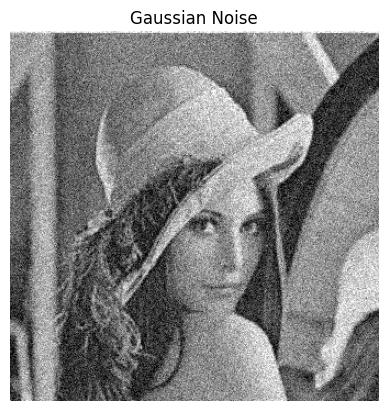

In [3]:
# 3. Add Noise
# (a) Gaussian Noise
gaussian_noise = random_noise(img_gray, mode='gaussian', var=0.01)
gaussian_noise = np.uint8(255 * gaussian_noise)

plt.imshow(gaussian_noise, cmap='gray')
plt.title("Gaussian Noise")
plt.axis('off')

(np.float64(-0.5), np.float64(335.5), np.float64(336.5), np.float64(-0.5))

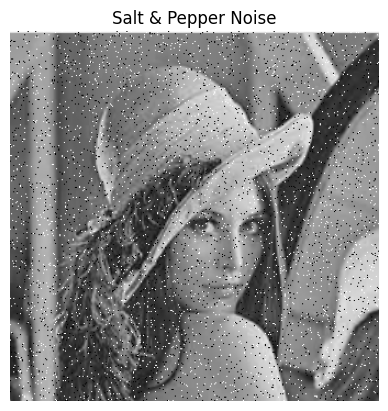

In [4]:
# Salt & Pepper Noise
sp_noise = random_noise(img_gray, mode='s&p', amount=0.05)
sp_noise = np.uint8(255 * sp_noise)

plt.imshow(sp_noise, cmap='gray')
plt.title("Salt & Pepper Noise")
plt.axis('off')

(np.float64(-0.5), np.float64(335.5), np.float64(336.5), np.float64(-0.5))

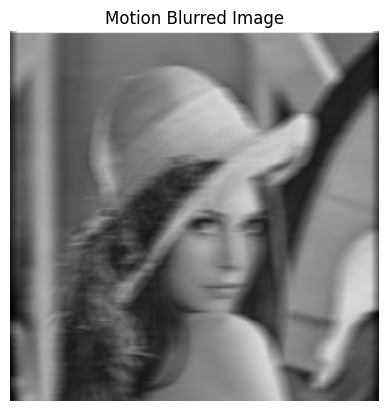

In [5]:
# Motion Blur
def motion_blur_kernel(size, angle):
    kernel = np.zeros((size, size))
    kernel[int((size-1)/2), :] = np.ones(size)
    kernel = kernel / size
    return kernel

kernel = motion_blur_kernel(15, 0)

motion_blur = convolve2d(img_gray, kernel, mode='same')

plt.imshow(motion_blur, cmap='gray')
plt.title("Motion Blurred Image")
plt.axis('off')

(np.float64(-0.5), np.float64(335.5), np.float64(336.5), np.float64(-0.5))

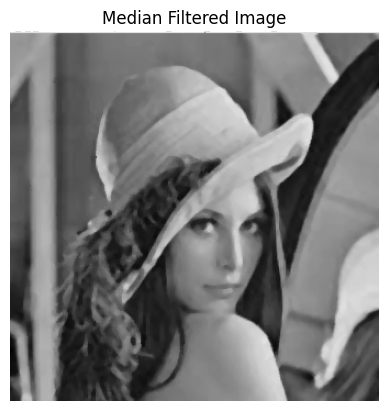

In [6]:
# Apply Filters
# (a) Median Filter (Best for Salt & Pepper)
median_filtered = cv2.medianBlur(sp_noise, 5)

plt.imshow(median_filtered, cmap='gray')
plt.title("Median Filtered Image")
plt.axis('off')

In [11]:
# Wiener Filter (Best for Gaussian)
from scipy.fftpack import fft2, ifft2

def wiener_filter(img, kernel, K=0.01):
    # Convert image to float
    img = img.astype(np.float32)

    # FFT of image
    img_fft = fft2(img)

    # Pad kernel to image size
    kernel_padded = np.zeros_like(img)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    # FFT of kernel
    kernel_fft = fft2(kernel_padded)

    # Avoid division by zero
    kernel_fft = np.where(kernel_fft == 0, 1e-8, kernel_fft)

    # Wiener filter formula
    wiener_filter = np.conj(kernel_fft) / (np.abs(kernel_fft)**2 + K)

    # Apply filter
    restored_fft = img_fft * wiener_filter
    restored = np.abs(ifft2(restored_fft))

    return restored



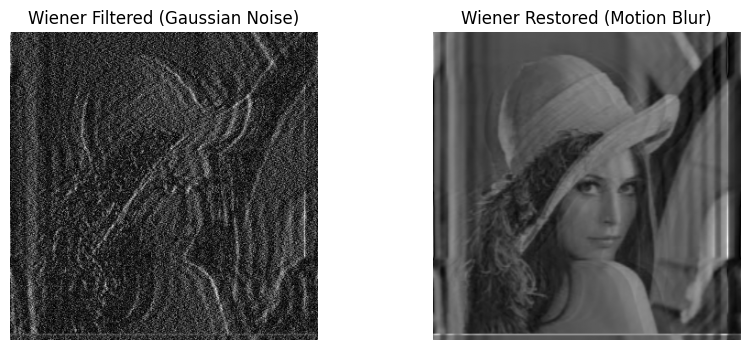

In [12]:
wiener_gaussian = wiener_filter(gaussian_noise, kernel, K=0.01)
wiener_motion = wiener_filter(motion_blur, kernel, K=0.01)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(wiener_gaussian, cmap='gray')
plt.title("Wiener Filtered (Gaussian Noise)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wiener_motion, cmap='gray')
plt.title("Wiener Restored (Motion Blur)")
plt.axis('off')

plt.show()


In [13]:
# Inverse Filtering
def inverse_filter(img, kernel):
    img = img.astype(np.float32)

    # FFT of image
    img_fft = fft2(img)

    # Pad kernel
    kernel_padded = np.zeros_like(img)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    # FFT of kernel
    kernel_fft = fft2(kernel_padded)

    # Avoid division by zero
    kernel_fft = np.where(kernel_fft == 0, 1e-8, kernel_fft)

    # Inverse filtering
    restored_fft = img_fft / kernel_fft
    restored = np.abs(ifft2(restored_fft))

    return restored


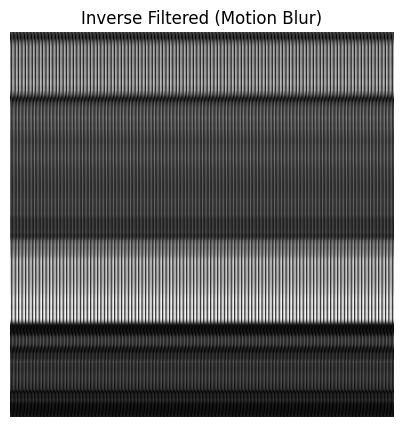

In [14]:
inverse_motion = inverse_filter(motion_blur, kernel)

plt.figure(figsize=(5,5))
plt.imshow(inverse_motion, cmap='gray')
plt.title("Inverse Filtered (Motion Blur)")
plt.axis('off')
plt.show()


(np.float64(-0.5), np.float64(335.5), np.float64(336.5), np.float64(-0.5))

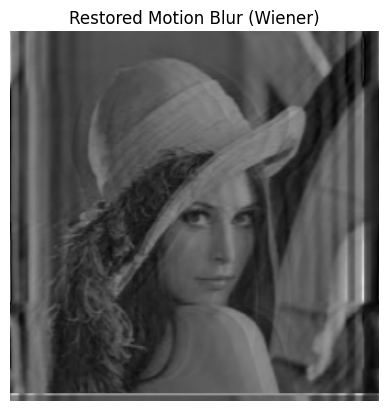

In [15]:
# Restore Motion Blurred Image (Using Wiener Filter)
motion_wiener = wiener_filter(motion_blur, kernel, K=0.01)

plt.imshow(motion_wiener, cmap='gray')
plt.title("Restored Motion Blur (Wiener)")
plt.axis('off')

In [16]:
# Compute PSNR
from skimage.metrics import peak_signal_noise_ratio as psnr

print("PSNR Values:\n")

print("Gaussian + Wiener Filter:",
      psnr(img_gray, wiener_gaussian))

print("Motion Blur + Inverse Filter:",
      psnr(img_gray, inverse_motion))

print("Motion Blur + Wiener Filter:",
      psnr(img_gray, wiener_motion))


PSNR Values:

Gaussian + Wiener Filter: 7.695185576197423
Motion Blur + Inverse Filter: -92.29877661741766
Motion Blur + Wiener Filter: 14.688946483219185


/tmp/ipython-input-1565919897.py:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr(img_gray, wiener_gaussian))
/tmp/ipython-input-1565919897.py:10: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr(img_gray, inverse_motion))
/tmp/ipython-input-1565919897.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr(img_gray, wiener_motion))


# Gaussian noise is best removed using Wiener filtering.
# Salt and pepper noise is effectively removed using median filtering.
# Motion blurred images are best restored using Wiener filtering compared to inverse filtering due to reduced noise amplification.